In [207]:
# imports:
import numpy as np
import math, os, pickle
from numpy import genfromtxt
import matplotlib
import matplotlib.pyplot as plt

import statistics


In [211]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def softmax(A):  
    expA = np.exp(A)
    return expA / expA.sum()

def load_objects(file):
    with open(file, 'rb') as input:
        return pickle.load(input)

# functions to use:
def sigmoid(matrix):
    #print("SIGMOID: \n" +str(matrix)+"\n")
    return 1/(1+np.exp(-matrix))

def getInputs(inputs):
    #add bias to layerOne and inputs
    row = inputs.shape[0] if np.ndim(inputs) != 1 else 1
    inputBias = np.ones((row,1)) if np.ndim(inputs) != 1 else np.ones((1))
    inputsWithBias = np.append(inputBias, inputs, 1) if np.ndim(inputs) != 1 else np.append(inputBias, inputs) 
    return inputsWithBias

def networkError(target, netResult):
    print("Target: " + str(target) + " Net Result: " + str(netResult))
    return .5*np.square(target - netResult)

def learning(weights, lr, error, activationsForLayer):
    print("Weights:  " + str(weights.shape))
    print("Learning Rate:  " + str(lr))
    print("Error:  " + str(error.shape))
    print("Activations: "+str(activationsForLayer.shape))
    return weights+lr*error*activationsForLayer

def hiddenUnitError(temp, activations, error):
    return temp*(1-temp)*(activations*error)

def outputError(target, output):
    # Eouput = output(1-output)(target - output)
    return output*(1-output)*(target - output)

def save_it_all(obj, filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
        
def saveNet(theta1, theta2, fileName):
    weights = {"theta1":theta1, "theta2":theta2}
    save_it_all(weights, fileName)
    
def sigmoidDerivative(target, output):
    #E = (t − y) * y *  (1− y) // note: derivative of sigmoid func
    return (target - output) * output * (1 - output)

def netPlot(instance, error):
    instance = list(range(0, instance))

    with plt.rc_context({'axes.edgecolor':'orange', 'xtick.color':'red', 'ytick.color':'green', 'figure.facecolor':'white'}):
        fig, ax = plt.subplots()
        ax.plot(instance, error)

        ax.set(xlabel='instance numebr (s)', ylabel='error (net)',
               title='Average Net Error for each batch run')
        ax.grid()

    plt.show()
    
def load_objects(file):
    with open(file, 'rb') as input:
        return pickle.load(input)
    
def classifyFish(inputInstance, theta1, theta2):
    # just need to feed forward 
    layerOneActivations = theta1.dot(np.transpose(inputInstance))
    print("\t\tLayer One activations: \n"+str(layerOneActivations)+"\n")
    layerOneSig = sigmoid(layerOneActivations)
    print("\t\tSigmoid Result: "+ str(layerOneSig) + "\n")
    inputsforhiddenlayer = getInputs(np.transpose(layerOneSig)) 
    print("\t\tInputs for the hiden layer is: (b,h1,h2)\n"+str(inputsforhiddenlayer)+"\n")

    outputActivation = theta2.dot(np.transpose(inputsforhiddenlayer)) 
    print("\t\tActivation for output layer: (h1,h2)\n" + str(outputActivation)+"\n")
        # inplace of sigmoid use softmax?? http://dataaspirant.com/2017/03/07/difference-between-softmax-function-and-sigmoid-function/
    outputFinal = sigmoid(outputActivation)
    print("\t\tFinal output: \n"+ str(outputFinal)+"\n")
    
    return "Yes" if outputFinal >= .5 else "No"


def getArrayFromFile(name):
    array = genfromtxt(name, delimiter=',')
    return array

In [214]:
# neural Net function:
def nn(learningRate, theta1, theta2, inputInstance, targetInstance):
    
    # feed forward:
    layerOneActivations = theta1.dot(np.transpose(inputInstance))
    print("\t\tLayer One activations: \n"+str(layerOneActivations.shape)+"\n")
    layerOneSig = sigmoid(layerOneActivations)
    print("\t\tSigmoid Result: "+ str(layerOneSig.shape) + "\n")
    inputsforhiddenlayer = getInputs(np.transpose(layerOneSig)) 
    print("\t\tInputs for the hiden layer is: (b,h1,h2)\n"+str(inputsforhiddenlayer.shape)+"\n")

    outputActivation = theta2.dot(np.transpose(inputsforhiddenlayer)) 
    print("\t\tActivation for output layer: (h1,h2)\n" + str(outputActivation.shape)+"\n")
        # inplace of sigmoid use softmax?? http://dataaspirant.com/2017/03/07/difference-between-softmax-function-and-sigmoid-function/
    outputFinal = sigmoid(outputActivation)
    print("\t\tFinal output: \n"+ str(outputFinal.shape)+"\n")

    # network error:
    netError = networkError(targetInstance, outputFinal)
    print("\t\tNetwork Error: \n" + str(netError.shape)+"\n")

    # BACKPROPAGATE
    outputErr = outputError(targetInstance, outputFinal[0])
    print("\t\tOutput Error: \n"+str(outputErr.shape)+"\n")

    hidUnitErr = hiddenUnitError(layerOneSig, layerOneActivations, outputErr)
    print("\t\tHidden unit errors: \n"+str(hidUnitErr.shape)+"\n")

    # learning:
    theta1 = learning(theta1, learningRate, hidUnitErr, inputInstance)
    print("\t\tNext round of weights for layerOne: (b,x1,x2) \n"+ str(theta1.shape)+"\n")

    theta2 = learning(theta2, learningRate, outputErr, inputsforhiddenlayer)
    print("\t\tNext round of weights for layer 2: (b,h1,h2) \n"+ str(theta2.shape)+"\n")
    
    return theta1, theta2, netError


In [215]:
#Main:

# load in fishing normalized set 
data = getArrayFromFile("normalizeFish.csv")
inputs = data[:,0:8] # get the input values
targets = data[:, 8:9] # get the class values

inputsWB = getInputs(inputs) # adds bias to the input matrix

numInputNodes = inputsWB.shape[1]
numOutputNodes = 1 if np.unique(targets).shape[0] == 2 else np.unique(targets).shape[0]
numHiddenNodes = int((2/3)*(numInputNodes+numOutputNodes)) # + 1 for the bias node

print("Input nodes with bias node: " + str(numInputNodes))
print("Output layer: " + str(numOutputNodes))
print("Hidden nodes with bias node: " + str(numHiddenNodes))

# inititlize weights
# (-1/sqrt(n)) < w < (1/sqrt(n))
lowRange = (-1/math.sqrt(numInputNodes))
highRange = math.fabs(lowRange)
theta1 = np.random.uniform(low=lowRange, high=highRange, size=(numHiddenNodes, numInputNodes))
theta2 = np.random.uniform(low=lowRange, high=highRange, size=(numOutputNodes,numHiddenNodes+1))

print("Theta1 dims: " + str(theta1.shape))
print("Theta2 dims: " + str(theta2.shape))


learningRate = .5
numberProcess = 0
batchError = []
for r in range(0, 100): # batch
    trackedNetError= []
    
    for index in range(0, inputsWB.shape[0]): # online
        print(color.CYAN+color.BOLD+"----------- Data for batch: "+str(r)+" Online Round: "+str(index)+" ------------"+color.END)
        print("Inputs: \n" + str(inputs[index])+"\n")
        print("Learning Rate: \n" + str(learningRate)+"\n")
        print("Theta One: \n" + str(theta1)+"\n")
        print("Theta two: \n" + str(theta2)+"\n")
        print("Target: \n"+ str(targets[index]) + "\n")
        print(color.YELLOW+color.BOLD+"----------Processing on batch:"+str(r)+" with online instance: "+str(index)+"-------------"+color.END)
        theta1, theta2, netError = nn(learningRate, theta1, theta2, np.array([inputsWB[index]]), targets[index])
        trackedNetError.append(netError[0][0])
    numberProcess = numberProcess + 1 
    batchError.append(statistics.mean(trackedNetError))
saveNet(theta1, theta2, "./FishWeights.pkl")


Input nodes with bias node: 9
Output layer: 1
Hidden nodes with bias node: 6
Theta1 dims: (6, 9)
Theta2 dims: (1, 7)
----------- Data for batch: 0 Online Round: 0 ------------
Inputs: 
[0. 1. 0. 0. 0. 1. 0. 0.]

Learning Rate: 
0.5

Theta One: 
[[-0.12849294 -0.22804686 -0.00297363  0.29226226 -0.07660649 -0.12789675
   0.07686363  0.0749551   0.13195334]
 [ 0.25691971  0.26077057 -0.1043421  -0.28624448 -0.21153169 -0.07793044
  -0.28985571 -0.19063245 -0.14977845]
 [ 0.29026041 -0.33307254  0.04354129 -0.22182266  0.28704634 -0.19694447
  -0.12994697  0.02173683  0.27173571]
 [ 0.01746822 -0.1431561   0.09744372 -0.0093446   0.25286677  0.08318129
   0.29925692 -0.24105671 -0.22569127]
 [-0.0625484   0.13144147  0.02333495  0.08687601 -0.30822278 -0.24011207
  -0.30224214 -0.07471252 -0.09750579]
 [ 0.26613735  0.18439254  0.1701771  -0.29386453 -0.05848052 -0.02431909
  -0.13604006 -0.08517676 -0.08401914]]

Theta two: 
[[ 0.07603219  0.0074263  -0.1464606   0.22685029 -0.22267373 -

Target: [0.] Net Result: [[0.62072501]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 3 Online Round: 0 ------------
Inputs: 
[0. 1. 0. 0. 0. 1. 0. 0.]

Learning Rate: 
0.5

Theta One: 
[[-0.07692902 -0.18554644  0.00298308  0.30188707 -0.04062409 -0.10906341
   0.11430474  0.07360315  0.1474281 ]
 [ 0.20211434  0.24275782 -0.12926805 -0.31406644 -0.21358915 -0.08564479
  -0.35629058 -0.19365667 -0.13512473]
 [ 0.25726366 -0.37010329  0.0726311  -0.25822299  0.26136011 -0.25559359
  -0.14922018  0.03692691  0.24282208]
 [ 0.08304095 -0.1443903   0.11472273  0.04487657  0.24693933  0.11643629
   0.36458666 -0.24529336 -0.22121162]
 [-0.06891476  0.16866161 -0.00535965  0.0555


Theta two: 
[[ 0.26185918  0.20418124 -0.17793648  0.25834595  0.02019182 -0.13024603
   0.17695761]]

Target: 
[0.]

----------Processing on batch:6 with online instance: 1-------------
		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,h2)
(1, 7)

		Activation for output layer: (h1,h2)
(1, 1)

		Final output: 
(1, 1)

Target: [0.] Net Result: [[0.61360458]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 6 Online Round: 2 ------------
Inputs: 
[0. 1. 0. 0. 0. 0. 1. 0.]

Learning Rate: 
0.5

Theta One: 
[[-0.02650553 -0.15690397  0.01439879  0.31800512 -0.01773434 -0.09661685
   0.16882453  0.07454487  0.14239009]
 [ 0.14053952

Theta two: 
[[ 0.27661524  0.26938512 -0.24825408  0.2370177   0.10636465 -0.16967326
   0.15767347]]

Target: 
[0.]

----------Processing on batch:8 with online instance: 13-------------
		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,h2)
(1, 7)

		Activation for output layer: (h1,h2)
(1, 1)

		Final output: 
(1, 1)

Target: [0.] Net Result: [[0.61316141]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 9 Online Round: 0 ------------
Inputs: 
[0. 1. 0. 0. 0. 1. 0. 0.]

Learning Rate: 
0.5

Theta One: 
[[ 0.02319774 -0.14056068  0.02517007  0.34466501 -0.00546225 -0.08710248
   0.23417849  0.07777219  0.12351208]
 [ 0.06922669

Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 12 Online Round: 2 ------------
Inputs: 
[0. 1. 0. 0. 0. 0. 1. 0.]

Learning Rate: 
0.5

Theta One: 
[[ 0.08138705 -0.14090846  0.0408977   0.38290436 -0.00123993 -0.07753738
   0.31575961  0.08375867  0.09413378]
 [-0.01098555  0.26043421 -0.22298736 -0.47027456 -0.17676162 -0.11005371
  -0.64828017 -0.22340075 -0.02649096]
 [ 0.2147855  -0.39855361  0.16145398 -0.37806844  0.24990451 -0.36172677
  -0.25160507  0.0829363   0.25671942]
 [ 0.2997297  -0.21076977  0.17661166  0.27183224  0.17478347  0.17592009
   0.65184925 -0.23723924 -0.29983957]
 [-0.20753437  0.25544072 -0.09817331 -0.10753496 -0.13728951 -0.18775028
  -0.60318527 -0.10900134  0.09274018]
 [ 0.17709243  0.03700024  0.20916559 -0.37811999 -0.10225848 -0.03770323
  -0.3000727  


Learning Rate: 
0.5

Theta One: 
[[ 0.14694463 -0.14999026  0.06029257  0.4315042  -0.00367705 -0.06731496
   0.40963017  0.09319882  0.05638066]
 [-0.09572444  0.28733174 -0.25979149 -0.54098284 -0.15398809 -0.11692842
  -0.76602529 -0.2425435   0.02565803]
 [ 0.20374464 -0.39595808  0.18997229 -0.42236856  0.25464546 -0.38707086
  -0.30168926  0.10097781  0.27772124]
 [ 0.37809478 -0.24382004  0.20221979  0.35702329  0.14234937  0.18461562
   0.76582044 -0.22622512 -0.34645981]
 [-0.28383443  0.28431129 -0.13380294 -0.18345923 -0.10203568 -0.1896101
  -0.70804619 -0.12656176  0.13886147]
 [ 0.15105812  0.02027273  0.22064847 -0.41863211 -0.09926353 -0.03933298
  -0.36344104 -0.01718865 -0.0396855 ]]

Theta two: 
[[ 0.12728339  0.3234111  -0.53175625  0.13148617  0.25184184 -0.42321397
   0.03209475]]

Target: 
[1.]

----------Processing on batch:15 with online instance: 2-------------
		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,

		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,h2)
(1, 7)

		Activation for output layer: (h1,h2)
(1, 1)

		Final output: 
(1, 1)

Target: [0.] Net Result: [[0.49527803]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 18 Online Round: 6 ------------
Inputs: 
[1. 0. 0. 1. 1. 1. 0. 0.]

Learning Rate: 
0.5

Theta One: 
[[ 0.22847064 -0.17120171  0.08949148  0.49500708 -0.01485283 -0.06083363
   0.51067998  0.11240053  0.01765514]
 [-0.1886536   0.32504572 -0.30692114 -0.61916448 -0.12160596 -0.11220272
  -0.87881154 -0.27610422  0.07907584]
 [ 0.19664219 -0.38700531  0.22649367 -0.46650755  0.25516062 -0.41460457
  -0.35520184


Theta One: 
[[ 0.3025945  -0.20438172  0.11823231  0.55282345 -0.02728617 -0.05395125
   0.6109074   0.13234957 -0.02839746]
 [-0.26696449  0.37083446 -0.34608103 -0.68440043 -0.09552102 -0.10875924
  -0.97845296 -0.3068103   0.13111245]
 [ 0.18969673 -0.37482681  0.25797832 -0.51004399  0.26026696 -0.43463374
  -0.40917117  0.1506603   0.32147276]
 [ 0.52460088 -0.33010906  0.26216263  0.51483774  0.07109818  0.17445075
   0.96412653 -0.18218424 -0.44230068]
 [-0.44775121  0.35952255 -0.21626073 -0.34342052 -0.02353338 -0.17450887
  -0.91021657 -0.18689881  0.23745212]
 [ 0.09150296  0.01093348  0.24964809 -0.52225023 -0.0842002  -0.04403718
  -0.50943193  0.01669934  0.01286223]]

Theta two: 
[[ 0.07283503  0.49377861 -0.84202753  0.06201391  0.49879288 -0.70345693
  -0.06795854]]

Target: 
[0.]

----------Processing on batch:21 with online instance: 5-------------
		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,h2)
(1, 7)

		Activa

		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 24 Online Round: 5 ------------
Inputs: 
[1. 0. 0. 1. 1. 0. 0. 1.]

Learning Rate: 
0.5

Theta One: 
[[ 0.37341124 -0.24796803  0.14908461  0.60759759 -0.04209587 -0.05098951
   0.70277163  0.15700635 -0.07410173]
 [-0.33601199  0.42335659 -0.38358973 -0.74154896 -0.06991128 -0.09948586
  -1.06082453 -0.34134869  0.1789749 ]
 [ 0.18804571 -0.35775325  0.29116086 -0.55064581  0.26603522 -0.45045475
  -0.46070623  0.17565358  0.34636352]
 [ 0.583944   -0.38093454  0.28886246  0.57690535  0.04167386  0.16381849
   1.0388606  -0.15606419 -0.48381168]
 [-0.51867547  0.4059436  -0.25222117 -0.41175906  0.00984134 -0.16299609
  -0.99228


Theta One: 
[[ 0.43790961 -0.29957718  0.1803744   0.65670108 -0.05799078 -0.05280712
   0.78142392  0.18581024 -0.11705954]
 [-0.39573257  0.48035642 -0.41846183 -0.79060965 -0.04569907 -0.08527124
  -1.12519452 -0.3786325   0.22090812]
 [ 0.19206617 -0.33808216  0.32622605 -0.58731565  0.27166033 -0.46260836
  -0.5075803   0.20294533  0.3699663 ]
 [ 0.63521569 -0.43537526  0.31423946  0.62991734  0.01455657  0.14846756
   1.09618768 -0.12645738 -0.51947388]
 [-0.58069999  0.4569785  -0.28579399 -0.4712712   0.04090178 -0.14668338
  -1.05738945 -0.25627695  0.32105436]
 [ 0.03524545  0.0358692   0.27611126 -0.62557124 -0.06359987 -0.04611938
  -0.65393618  0.04691756  0.07089075]]

Theta two: 
[[-0.03072422  0.65728205 -1.17980726 -0.02113325  0.71793887 -1.02276648
  -0.2041985 ]]

Target: 
[0.]

----------Processing on batch:27 with online instance: 5-------------
		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,h2)
(1, 7)

		Activa

		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,h2)
(1, 7)

		Activation for output layer: (h1,h2)
(1, 1)

		Final output: 
(1, 1)

Target: [0.] Net Result: [[0.28060211]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 30 Online Round: 6 ------------
Inputs: 
[1. 0. 0. 1. 1. 1. 0. 0.]

Learning Rate: 
0.5

Theta One: 
[[ 0.49592288 -0.35562618  0.21062629  0.69952482 -0.07305314 -0.05839132
   0.84522432  0.21787786 -0.15491428]
 [-0.44836007  0.53858167 -0.4499484  -0.83273522 -0.02471443 -0.06859627
  -1.17298963 -0.41752704  0.25497027]
 [ 0.20174799 -0.31803582  0.36311343 -0.61974063  0.27687975 -0.47149464
  -0.54866753


Theta two: 
[[-0.14807426  0.81777895 -1.51044044 -0.08352437  0.90606408 -1.33646577
  -0.34268108]]

Target: 
[0.]

----------Processing on batch:33 with online instance: 9-------------
		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,h2)
(1, 7)

		Activation for output layer: (h1,h2)
(1, 1)

		Final output: 
(1, 1)

Target: [0.] Net Result: [[0.55474279]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 33 Online Round: 10 ------------
Inputs: 
[1. 0. 1. 0. 1. 1. 0. 0.]

Learning Rate: 
0.5

Theta One: 
[[ 0.53341405 -0.42888943  0.23874041  0.72889598 -0.09304725 -0.08714472
   0.89659391  0.25219884 -0.20311369]
 [-0.47576


Theta two: 
[[-0.22742201  0.86365529 -1.65342263 -0.11028773  0.95574598 -1.47237975
  -0.40482661]]

Target: 
[1.]

----------Processing on batch:36 with online instance: 8-------------
		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,h2)
(1, 7)

		Activation for output layer: (h1,h2)
(1, 1)

		Final output: 
(1, 1)

Target: [1.] Net Result: [[0.65821871]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 36 Online Round: 9 ------------
Inputs: 
[0. 0. 1. 0. 1. 0. 0. 1.]

Learning Rate: 
0.5

Theta One: 
[[ 0.58863276 -0.49076911  0.26398395  0.7743524  -0.1085285  -0.08813951
   0.93322517  0.28779374 -0.22012113]
 [-0.524661

Target: [1.] Net Result: [[0.76332583]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 39 Online Round: 8 ------------
Inputs: 
[0. 0. 0. 1. 1. 1. 0. 0.]

Learning Rate: 
0.5

Theta One: 
[[ 0.61687329 -0.55254017  0.28591378  0.80307062 -0.13093602 -0.11312969
   0.95273079  0.3238115  -0.24740397]
 [-0.5459408   0.74095025 -0.52009074 -0.93577589  0.05088785  0.01886729
  -1.23319063 -0.53451462  0.33457813]
 [ 0.27195037 -0.25305614  0.47985012 -0.70042005  0.31102485 -0.46313075
  -0.63344129  0.33056569  0.44809112]
 [ 0.76336317 -0.68974626  0.39345279  0.78740241 -0.09399436  0.03838074
   1.17918023  0.01036453 -0.61114087]
 [-0.73813588  0.70112188 -0.3851318  -0.646

Learning Rate: 
0.5

Theta One: 
[[ 6.46066681e-01 -6.12948295e-01  3.04302034e-01  8.26245242e-01
  -1.43305505e-01 -1.30876494e-01  9.70607855e-01  3.59574668e-01
  -2.71850825e-01]
 [-5.68947850e-01  8.02028601e-01 -5.34983327e-01 -9.60494295e-01
   6.74917935e-02  4.49304300e-02 -1.23924342e+00 -5.71495656e-01
   3.54604907e-01]
 [ 3.02773890e-01 -2.42449084e-01  5.18341470e-01 -7.16919569e-01
   3.19856545e-01 -4.59640700e-01 -6.54236471e-01  3.64808031e-01
   4.65467482e-01]
 [ 7.83275496e-01 -7.51133125e-01  4.06121509e-01  8.14907140e-01
  -1.14255479e-01  1.03376796e-02  1.17930854e+00  4.54745641e-02
  -6.26466874e-01]
 [-7.62009470e-01  7.59954001e-01 -3.99987413e-01 -6.76097682e-01
   1.78612207e-01 -7.70338179e-03 -1.17093738e+00 -4.47587748e-01
   4.44603606e-01]
 [-6.25374747e-03  1.85642832e-01  3.65200534e-01 -8.21054465e-01
   1.29488179e-03 -1.21737407e-03 -8.84266032e-01  1.30382152e-01
   1.76256816e-01]]

Theta two: 
[[-0.31690635  0.99073306 -1.90255575 -0.120720


		Final output: 
(1, 1)

Target: [1.] Net Result: [[0.68174409]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 45 Online Round: 9 ------------
Inputs: 
[0. 0. 1. 0. 1. 0. 0. 1.]

Learning Rate: 
0.5

Theta One: 
[[ 0.68629468 -0.67101742  0.31908415  0.85432406 -0.14593843 -0.14118903
   0.99797528  0.39458776 -0.29400334]
 [-0.60241201  0.86065003 -0.54578863 -0.98943825  0.07377689  0.06248233
  -1.25523831 -0.60689415  0.37253412]
 [ 0.32270671 -0.23616718  0.55546109 -0.73957215  0.32532233 -0.45887221
  -0.68543905  0.39888288  0.48252803]
 [ 0.81405354 -0.81084208  0.41566805  0.84655571 -0.12467254 -0.00956853
   1.18919244  0.0799001  -0.63999827]
 [-0.79643094  0.8

Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 48 Online Round: 10 ------------
Inputs: 
[1. 0. 1. 0. 1. 1. 0. 0.]

Learning Rate: 
0.5

Theta One: 
[[ 0.69842459 -0.72609541  0.33032477  0.86327236 -0.15399745 -0.17323585
   1.01090683  0.4285228  -0.32874003]
 [-0.60843275  0.9161     -0.55274659 -0.99964496  0.08492083  0.10099234
  -1.25857979 -0.64059308  0.4035538 ]
 [ 0.35606661 -0.2342138   0.59076651 -0.75137439  0.33517905 -0.44741825
  -0.70848347  0.43232902  0.50548622]
 [ 0.81902293 -0.86793908  0.42214169  0.86028295 -0.13990403 -0.04944994
   1.18675932  0.11336154 -0.6660572 ]
 [-0.80367638  0.8717718  -0.4179728  -0.7244446   0.20327761  0.05051861
  -1.18729522 -0.51709781  0.4888046 ]
 [-0.0029985   0.23689742  0.40977939 -0.87296696  0.01188377  0.02523609
  -0.95826742  0.16811477  0.21578084]]

Theta two: 
[[-0.39874778  1.114262   -2.13487407 -0.12447735  1.21750811 -1.93133254
  -0.57672458]]

Target: 
[1

		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,h2)
(1, 7)

		Activation for output layer: (h1,h2)
(1, 1)

		Final output: 
(1, 1)

Target: [1.] Net Result: [[0.71949975]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 51 Online Round: 11 ------------
Inputs: 
[1. 0. 1. 0. 0. 1. 0. 0.]

Learning Rate: 
0.5

Theta One: 
[[ 0.72896731 -0.77154828  0.33819236  0.89145175 -0.15950171 -0.18382498
   1.02791451  0.46119297 -0.34787515]
 [-0.63350621  0.96183486 -0.5561623  -1.02927328  0.0928914   0.11690082
  -1.26713639 -0.67257938  0.41902324]
 [ 0.37544047 -0.24249378  0.62402831 -0.77502792  0.34494464 -0.4488444
  -0.73793251


Target: 
[1.]

----------Processing on batch:54 with online instance: 11-------------
		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,h2)
(1, 7)

		Activation for output layer: (h1,h2)
(1, 1)

		Final output: 
(1, 1)

Target: [1.] Net Result: [[0.76125826]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 54 Online Round: 12 ------------
Inputs: 
[0. 1. 0. 0. 1. 1. 0. 0.]

Learning Rate: 
0.5

Theta One: 
[[ 0.75584144 -0.81536524  0.34293499  0.91659886 -0.16251732 -0.19980507
   1.04162894  0.49252124 -0.36604372]
 [-0.65544894  1.00566011 -0.55638598 -1.05589959  0.09779865  0.13715833
  -1.27359868 -0.70291254  0.43387595]


Learning Rate: 
0.5

Theta One: 
[[ 0.76548956 -0.87137208  0.34485512  0.92505635 -0.16324682 -0.22083573
   1.03877546  0.52250886 -0.38352975]
 [-0.66083084  1.06125971 -0.55379331 -1.06599563  0.09992012  0.16162113
  -1.26472022 -0.73169723  0.44840029]
 [ 0.42785945 -0.25044324  0.68436826 -0.80135725  0.363353   -0.43502785
  -0.77936514  0.52609462  0.55439513]
 [ 0.86901763 -1.01924939  0.42485333  0.93405513 -0.16639315 -0.11586712
   1.17768451  0.20676415 -0.7003903 ]
 [-0.85703682  1.01684703 -0.41963586 -0.80012319  0.22725881  0.1145323
  -1.18800988 -0.60918098  0.528242  ]
 [ 0.00824787  0.29119594  0.48164151 -0.94929221  0.02759327  0.05755972
  -1.04444687  0.22808274  0.25323868]]

Theta two: 
[[-0.49045597  1.28919919 -2.43132976 -0.11119157  1.39246684 -2.21285556
  -0.67446699]]

Target: 
[1.]

----------Processing on batch:57 with online instance: 10-------------
		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1

Target: [1.] Net Result: [[0.79791832]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 60 Online Round: 13 ------------
Inputs: 
[1. 0. 1. 0. 0. 0. 0. 1.]

Learning Rate: 
0.5

Theta One: 
[[ 7.98036073e-01 -9.03232379e-01  3.47735549e-01  9.53444855e-01
  -1.61969241e-01 -2.25315342e-01  1.05963267e+00  5.51206923e-01
  -4.00538504e-01]
 [-6.88756785e-01  1.09290894e+00 -5.51824684e-01 -1.09559126e+00
   9.96211810e-02  1.69456532e-01 -1.27967412e+00 -7.59060833e-01
   4.62791848e-01]
 [ 4.37788776e-01 -2.71550417e-01  7.11285272e-01 -8.26747076e-01
   3.71755135e-01 -4.38851054e-01 -8.14300767e-01  5.54759572e-01
   5.70595124e-01]
 [ 8.97006294e-01 -1.05298815e+00  4.24051


----------Processing on batch:64 with online instance: 3-------------
		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,h2)
(1, 7)

		Activation for output layer: (h1,h2)
(1, 1)

		Final output: 
(1, 1)

Target: [1.] Net Result: [[0.59446156]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 64 Online Round: 4 ------------
Inputs: 
[0. 0. 0. 1. 1. 0. 0. 1.]

Learning Rate: 
0.5

Theta One: 
[[ 0.81953562 -0.96046777  0.34024022  0.97946084 -0.15899035 -0.23868637
   1.05215338  0.5876015  -0.40795424]
 [-0.70615212  1.1492402  -0.53893026 -1.12355084  0.09729099  0.18515628
  -1.26696872 -0.79356437  0.46719464]
 [ 0.46862875 -0


Target: 
[0.]

----------Processing on batch:67 with online instance: 1-------------
		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,h2)
(1, 7)

		Activation for output layer: (h1,h2)
(1, 1)

		Final output: 
(1, 1)

Target: [0.] Net Result: [[0.62985326]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 67 Online Round: 2 ------------
Inputs: 
[0. 1. 0. 0. 0. 0. 1. 0.]

Learning Rate: 
0.5

Theta One: 
[[ 0.81552744 -0.99713973  0.32662117  0.98469131 -0.15460994 -0.25138264
   1.05765287  0.60505648 -0.43491689]
 [-0.69906611  1.18556945 -0.52159481 -1.12981186  0.09330258  0.1997646
  -1.26841734 -0.81005133  0.49221624]
 [


Target: 
[0.]

----------Processing on batch:70 with online instance: 1-------------
		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,h2)
(1, 7)

		Activation for output layer: (h1,h2)
(1, 1)

		Final output: 
(1, 1)

Target: [0.] Net Result: [[0.62058999]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 70 Online Round: 2 ------------
Inputs: 
[0. 1. 0. 0. 0. 0. 1. 0.]

Learning Rate: 
0.5

Theta One: 
[[ 0.82997967 -1.03151994  0.32048945  0.99976973 -0.14910442 -0.26353635
   1.06280478  0.63038364 -0.45094373]
 [-0.71011457  1.21959781 -0.51140051 -1.14574518  0.08799314  0.21349413
  -1.26999336 -0.83392066  0.50661312]
 

Learning Rate: 
0.5

Theta One: 
[[ 0.85124012 -1.06380233  0.32115334  1.0139814  -0.14271953 -0.2752627
   1.06769907  0.66267941 -0.46687334]
 [-0.72767075  1.25153548 -0.50767345 -1.16069269  0.08165741  0.22652457
  -1.27171494 -0.86428984  0.52114771]
 [ 0.5150144  -0.32896589  0.81393676 -0.87962379  0.39920599 -0.43931461
  -0.91071818  0.66446468  0.63453305]
 [ 0.94063984 -1.21814424  0.38666859  1.03878238 -0.16131346 -0.18513681
   1.16776841  0.34839626 -0.7604841 ]
 [-0.92605739  1.20922503 -0.37442051 -0.90577316  0.21867287  0.18143619
  -1.18800533 -0.74372288  0.59375878]
 [ 0.03247936  0.3263704   0.6154964  -1.06196144  0.03063909  0.09468528
  -1.18785148  0.33918953  0.30976799]]

Theta two: 
[[-0.6030216   1.56109268 -2.85258656 -0.08650949  1.66653534 -2.61538391
  -0.80953798]]

Target: 
[1.]

----------Processing on batch:73 with online instance: 3-------------
		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,h

		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,h2)
(1, 7)

		Activation for output layer: (h1,h2)
(1, 1)

		Final output: 
(1, 1)

Target: [1.] Net Result: [[0.67820437]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 76 Online Round: 3 ------------
Inputs: 
[0. 0. 1. 0. 0. 0. 0. 1.]

Learning Rate: 
0.5

Theta One: 
[[ 0.86331292 -1.09415075  0.31275001  1.02740701 -0.135669   -0.28665915
   1.07241832  0.68588486 -0.48272524]
 [-0.73669038  1.28155311 -0.49553008 -1.17474617  0.07454788  0.23900457
  -1.27360931 -0.88607937  0.53581198]
 [ 0.52945556 -0.34460746  0.83480441 -0.89139398  0.40454968 -0.44211718
  -0.93417092

		Activation for output layer: (h1,h2)
(1, 1)

		Final output: 
(1, 1)

Target: [1.] Net Result: [[0.68450875]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 79 Online Round: 3 ------------
Inputs: 
[0. 0. 1. 0. 0. 0. 0. 1.]

Learning Rate: 
0.5

Theta One: 
[[ 0.87454863 -1.12270313  0.30374056  1.04011909 -0.12813593 -0.2978065
   1.07703764  0.70828244 -0.49850643]
 [-0.74503093  1.30978857 -0.48295638 -1.18799061  0.06687807  0.2510556
  -1.27570897 -0.90709488  0.55058659]
 [ 0.54319035 -0.36038141  0.85492819 -0.90255764  0.40932435 -0.44589971
  -0.9571904   0.70804066  0.66560524]
 [ 0.96076081 -1.27927541  0.36527944  1.06902497 -0.15004592 -0.21000635
   1.16719488

Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 82 Online Round: 4 ------------
Inputs: 
[0. 0. 0. 1. 1. 0. 0. 1.]

Learning Rate: 
0.5

Theta One: 
[[ 0.89485043 -1.14957734  0.29433031  1.06197048 -0.12027527 -0.30877049
   1.08162292  0.72991832 -0.50442579]
 [-0.7625558   1.3363552  -0.470165   -1.21025541  0.05882664  0.26277565
  -1.27804651 -0.92738759  0.55569198]
 [ 0.55980313 -0.37613467  0.87438906 -0.90963985  0.41355848 -0.45060096
  -0.9797127   0.72835756  0.68442343]
 [ 0.97952235 -1.30716493  0.35412223  1.09238472 -0.14348692 -0.22171454
   1.1675371   0.41725928 -0.79023331]
 [-0.96187004  1.295845   -0.33714529 -0.95955013  0.19936196  0.21731133
  -1.19132809 -0.80784973  0.62539573]
 [ 0.04186789  0.32953833  0.69078814 -1.12159036  0.02436481  0.11733274
  -1.26429217  0.40163248  0.


Theta two: 
[[-0.69744667  1.72562971 -3.13155564 -0.08075904  1.8331711  -2.88358996
  -0.90724163]]

Target: 
[1.]

----------Processing on batch:85 with online instance: 3-------------
		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,h2)
(1, 7)

		Activation for output layer: (h1,h2)
(1, 1)

		Final output: 
(1, 1)

Target: [1.] Net Result: [[0.62871456]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 85 Online Round: 4 ------------
Inputs: 
[0. 0. 0. 1. 1. 0. 0. 1.]

Learning Rate: 
0.5

Theta One: 
[[ 0.90461312 -1.17487707  0.28469448  1.07331032 -0.11221659 -0.31960313
   1.08622877  0.75083031 -0.52018093]
 [-0.769731


Target: 
[0.]

----------Processing on batch:88 with online instance: 6-------------
		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,h2)
(1, 7)

		Activation for output layer: (h1,h2)
(1, 1)

		Final output: 
(1, 1)

Target: [0.] Net Result: [[0.22135525]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 88 Online Round: 7 ------------
Inputs: 
[0. 0. 1. 0. 0. 1. 0. 0.]

Learning Rate: 
0.5

Theta One: 
[[ 0.91216851 -1.20040862  0.27497844  1.08412208 -0.10575692 -0.33203408
   1.08918413  0.77104952 -0.53580011]
 [-0.77498787  1.38646792 -0.44461728 -1.23310841  0.04369984  0.28707253
  -1.28192908 -0.96595999  0.58571488]
 


Theta One: 
[[ 0.92268746 -1.22112639  0.26529881  1.09445455 -0.09589081 -0.34099924
   1.09565612  0.79060211 -0.55130576]
 [-0.78311831  1.40696803 -0.43212459 -1.24371474  0.03368304  0.29659432
  -1.2867207  -0.98429919  0.60071526]
 [ 0.59668028 -0.42220406  0.92928601 -0.93716792  0.42306675 -0.46986175
  -1.04385607  0.78393575  0.72986576]
 [ 1.00464658 -1.38139612  0.32073669  1.12941174 -0.12200418 -0.25498845
   1.17104241  0.47984924 -0.83120433]
 [-0.98361704  1.36820367 -0.29918407 -0.99661969  0.1767233   0.25012452
  -1.19757719 -0.86570984  0.66775794]
 [ 0.05871836  0.32398837  0.7638465  -1.1686848   0.01525136  0.1378203
  -1.33655528  0.46219647  0.36170386]]

Theta two: 
[[-0.6992086   1.83595002 -3.25201848 -0.05474441  1.9436324  -2.99864631
  -0.93880294]]

Target: 
[0.]

----------Processing on batch:91 with online instance: 6-------------
		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,h2)
(1, 7)

		Activat


Theta One: 
[[ 0.93002857 -1.24361119  0.2557456   1.10461733 -0.08915927 -0.35298831
   1.09942892  0.80951076 -0.56664609]
 [-0.78841033  1.42900042 -0.41994479 -1.25408341  0.02657989  0.30885079
  -1.28918584 -1.00203851  0.61562769]
 [ 0.61102798 -0.43388085  0.94651064 -0.94553828  0.42856018 -0.47452433
  -1.06142996  0.80079455  0.74492855]
 [ 1.01112967 -1.40483924  0.31000658  1.14083849 -0.11621772 -0.26725855
   1.17169155  0.49943022 -0.84495136]
 [-0.98913478  1.39098396 -0.28700912 -1.00806815  0.17047906  0.26214462
  -1.19916041 -0.88374674  0.68186032]
 [ 0.06675208  0.32361563  0.78743414 -1.18378039  0.01479303  0.14722363
  -1.35713547  0.48172611  0.37078813]]

Theta two: 
[[-0.73391402  1.86559935 -3.32055932 -0.05799883  1.97376505 -3.06484505
  -0.96496035]]

Target: 
[1.]

----------Processing on batch:94 with online instance: 8-------------
		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,h2)
(1, 7)

		Activa

Target: [0.] Net Result: [[0.54791113]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 97 Online Round: 10 ------------
Inputs: 
[1. 0. 1. 0. 1. 1. 0. 0.]

Learning Rate: 
0.5

Theta One: 
[[ 0.92800827 -1.26338101  0.24638509  1.1000278  -0.07722952 -0.37369265
   1.10833655  0.82779587 -0.59585914]
 [-0.78435456  1.44840973 -0.40813847 -1.24969781  0.01444374  0.32993098
  -1.29682552 -1.01919769  0.64448232]
 [ 0.62132458 -0.4484096   0.96321732 -0.95177414  0.42838596 -0.48412556
  -1.08314594  0.81687718  0.76085849]
 [ 1.00898178 -1.42529121  0.29959423  1.13790142 -0.1050162  -0.28757095
   1.17788855  0.51839906 -0.87226509]
 [-0.98584998  1.41091556 -0.27520103 -1.00

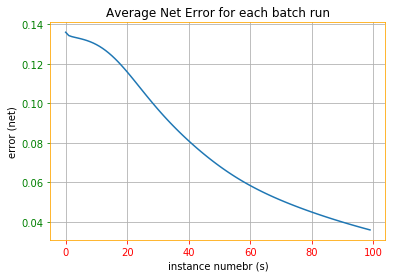

In [206]:
netPlot(numberProcess, batchError)

In [190]:
# remember for this set you target yes as 1 and no as 0, confusing I know
weightMap = load_objects("./FishWeights.pkl")
theta1 = weightMap["theta1"]
theta2 = weightMap["theta2"]

test = getArrayFromFile("normalizeFishTest.csv")
print(test)
print(test.shape)
test = getInputs(test)

testInstance = test

classifyFish(testInstance, theta1, theta2)


[0. 0. 0. 1. 0. 1. 0. 0.]
(8,)
[1.]
		Layer One activations: 
[-0.4560759  -1.8905096  -1.49066094  1.05197795 -1.30777151  0.86557503
 -1.93706421]

		Sigmoid Result: [0.38791714 0.13118638 0.18382255 0.74115454 0.21285999 0.70382412
 0.12597074]

[1.]
		Inputs for the hiden layer is: (b,h1,h2)
[1.         0.38791714 0.13118638 0.18382255 0.74115454 0.21285999
 0.70382412 0.12597074]

		Activation for output layer: (h1,h2)
[0.61300909]

		Final output: 
[0.64862691]



'Yes'